## Análisis multivariado

En esta sección se realiza el análisis multivariado del proyecto, la idea detrás de dicho apartado es identificar efectos simultáneos que diferentes variables predictoras podrían tener sobre el target. Por un lado, el estudio multivariante permitiría determinar posibles efectos indirectos que una predictora puede tener sobre el target, a partir de un tercer *feature*. Por otro lado, ayudaría a encontrar posibles correlaciones no despreciables entre variables independientes que sugerirían la eliminación de alguna de ellas en pos de reducir la complejidad del modelo. 

La sección se estructura de la siguiente manera. En primer lugar, realizamos la carga de las librerías que vamos a utilizar como el dataset objetivo. Este último será reducido al período de tiempo que corresponde al grupo de entrenamiento, cuya explicación de la creación de este subconjunto de datos se dió en el [**análisis bivariado**](https://colab.research.google.com/drive/1yY5Z5Sr65W-V0U5Xm_v1Iri0S9_E08_s#scrollTo=xUxe8UqFzGEG). En segundo lugar, se crean tres variables categóricas que interesan incorporara al análisis multivariado. Los mismos son los siguientes: 

1. Variable binaria que indique si la variación interdiaria del precio del bitcoin es positiva o no
2. Shock Covid-19
3. Ingreso de ethereum al *exchange* Binance

La primera hace mención a la variación entre dos días del precio de bitcoin. Como vimos en análisis anteriores, el precio del bitcoin está considerablemente asociado positivamente al precio de ethereum y puede ser un importante predictor directo de la cotización futura del target. La pregunta ahora sería si hay un efecto indirecto entre el precio actual de ambas criptomonedas que puede correlacionar con la cotización futura de ethereum, es decir, interesa analizar si la cotización de bitcoin tiene un efecto en el precio actual de ethereum que podría relacionarse con los movimientos futuros de esta criptomoneda. 

En el segundo caso, el shock exógeno del covid-19 generó una disrupción importante tanto en el ámbito cotidiano de las personas como en los mercados financieros. Siguiendo a [**El País**](https://elpais.com/economia/2020-03-12/las-bolsas-sufren-en-la-apertura-y-el-ibex-cae-mas-de-un-5.html), el 12 de marzo del 2020 se recuerda como un "terremoto económico global de una magnitud impredecible", con el desplome global de las bolsas a partir de los pronósticos poco alentadores acerca de la trayectoria de las economías post-covid. Debido a esto, en esta sección queremos ver qué rasgos podríamos encontrar al separar la base en dos momentos diferentes, un período pre-covid y uno post-covid. Eligiendo al 12 de marzo del 2020 como momento bisagra. 

Por último, un segundo quiebre que queremos analizar se encuentra en el posicionamiento de ethereum como una inversión globalmente popular dentro del mercado de criptomonedas y su relación con otras variables correlacionadas altamente con otros predictores. Para ello, utilizamos como *proxy* la fecha en donde se funda [**Binance**](https://www.binance.com/en/support/announcement/115000599831), una de las plataformas más grandes e importantes de *trading* de criptomonedas. 

In [1]:
import pandas as pd 
import numpy as np # numpy y pandas to data wrangling 
from datetime import datetime, timedelta # to work w date
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import seaborn as sns
import scipy as scp

In [2]:
# importamos dataset
aux = 'https://drive.google.com/file/d/1GWaKdMRk4Fx9qGgBMioNeO3E7_I3bA8k/view?usp=sharing'
link ='https://drive.google.com/uc?id=' + aux.split('/')[-2]
df = pd.read_csv(link)
df = df.set_index('Date')

# subconjunto a utilizar: dataset de entrenamiento
start = df.index[0]
# Enfoque de validación
train = df[start:'2020-12-31']
train.head()

,Volume USDT_btc,cryptocurrency_adjusted,crypto_adjusted,bitcoin_adjusted,bitcoin price_adjusted,ethereum_adjusted,ethereum price_adjusted,stock market_adjusted,wall street_adjusted,interest rate_adjusted,...,y_lag4,y_lag5,y_lag6,y_lag7,unix_btc,open_btc,high_btc,low_btc,close_btc,Volume BTC_btc
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-08,3.8010,0.0,0.48,1.74,0.27,0.0,0.0,1.45,8.32,16.38,...,2.150,1.825,1.310,1.645,1438992000,275.92,282.24,262.65,263.00,1032.69
2015-08-11,0.9435,0.0,0.88,1.89,0.49,0.0,0.0,2.61,9.92,19.74,...,1.825,1.310,1.645,1.520,1439251200,266.22,269.26,261.61,269.26,247.49
2015-08-12,2.5580,0.0,0.87,1.83,0.47,0.0,0.0,3.48,10.40,20.58,...,1.310,1.645,1.520,1.410,1439337600,269.26,275.63,263.33,265.41,682.19
2015-08-13,3.1890,0.0,0.87,1.95,0.35,0.0,0.0,2.61,10.40,18.48,...,1.645,1.520,1.410,1.515,1439424000,265.41,269.88,260.00,263.00,838.99
2015-08-14,2.1290,0.0,0.83,1.68,0.32,0.0,0.0,2.32,10.88,16.80,...,1.520,1.410,1.515,1.615,1439510400,263.00,265.00,255.00,265.00,556.23


### Variación interdiaria del bitcoin

In [3]:
# creación de dummy de si la variación entre días subió o no
train['var_price_btc'] = train['open_btc'].div(train['open_btc'].shift(1))-1
train.loc[train['var_price_btc'] <= 0,'var_price'] = 'No subió'
train.loc[train['var_price_btc'] > 0,'var_price'] = 'Subió'

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_11840\4183162993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['var_price_btc'] = train['open_btc'].div(train['open_btc'].shift(1))-1
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_11840\4183162993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[train['var_price_btc'] <= 0,'var_price'] = 'No subió'


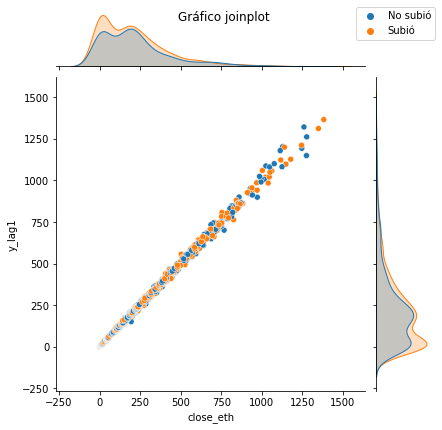

In [4]:
# gráfico multivariado var id precio bitcoin versus target
p = sns.jointplot(data=train, x="close_eth", y="y_lag1", hue='var_price')
p.fig.suptitle("Gráfico joinplot")

# omito la legenda default
p.ax_joint.legend_._visible=False
p.fig.legend(bbox_to_anchor=(1, 1), loc=1);

Como se puede ver en el gráfico anterior, los resultados no sugieren un efecto indirecto de la variación interdiaria del bitcoin en la cotización futura de ethereum, a través del precio actual de ethereum. De hecho, las distribuciones son bastantes similares aún diferenciando por la categórica de si el precio entre días de bitcoin subió o no. El gráfico podría indicar que sería casi indiferente entre incluir la cotización del precio presente del bitcoin como el de ethereum. 

### Período pre pandemia y post pandemia

In [5]:
# creación de dummy pre y post pandemia
train.loc[train.index < '2020-03-12', 'Shock-COVID'] = 'Pre-COVID'
train.loc[train.index >= '2020-03-12', 'Shock-COVID'] = 'Post-COVID'

train.loc[train.index < '2017-08-17', 'Binance-Listing'] = 'No-Listado'
train.loc[train.index >= '2017-08-17', 'Binance-Listing'] = 'Listado'

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_11840\2790761375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[train.index < '2020-03-12', 'Shock-COVID'] = 'Pre-COVID'
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_11840\2790761375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[train.index < '2017-08-17', 'Binance-Listing'] = 'No-Listado'


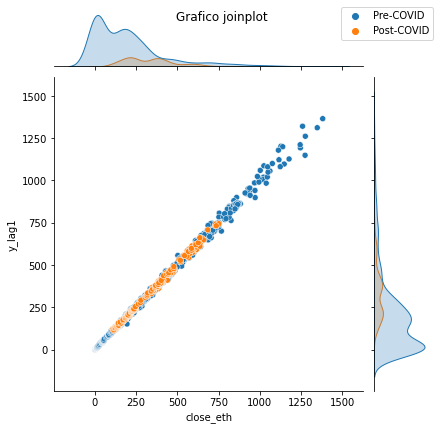

In [6]:
# Comparación precio ethereum real contra precio ethereum predicho 
# para el día siguiente según el shock de COVID 

p = sns.jointplot(data=train, x="close_eth", y="y_lag1", hue='Shock-COVID')
p.fig.suptitle("Grafico joinplot")

# omito la legenda default
p.ax_joint.legend_._visible=False
p.fig.legend(bbox_to_anchor=(1, 1), loc=1);

En contraste, la separación de períodos pre y post pandemia no resulta indiferente al evaluar la correlación entre el precio presente de ethereum y su cotización futura. Claramente, la correlación entre variables se da en los tramos de menores precios en contexto de pandemia, lo que indica no sólo que dicho acontecimiento global contrajo los precios de la criptomoneda, sino que la pandemia podría influenciar negativamente el precio corriente de ethereum y afectar así la cotización futura de la misma. Debido a esto, resulta imporante agregar dicha variable binaria al análisis. 

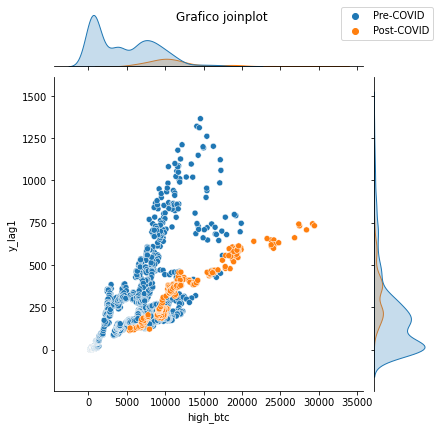

In [7]:
# Comparación precio bitcoin contra precio ethereum predicho 
# para el día siguiente según el shock de COVID 

p = sns.jointplot(data=train, x="high_btc", y="y_lag1", hue='Shock-COVID')
p.fig.suptitle("Grafico joinplot")

#omito la legenda default
p.ax_joint.legend_._visible=False
p.fig.legend(bbox_to_anchor=(1, 1), loc=1);

Aún más interesante resulta la influencia que podría darse entre el período pre y post pandemia con la correlación entre el precio más alto del día de bitcoin con la cotización futura de ethereum. El gráfico anterior sugiere un cambio de trayectoria de la correlación entre ambas variables. Dada una cotización del precio más alto de bitcoin se generan dos niveles de precios distintos según qué período se está evaluando, por lo que la categoría *shock-covid* se correlaciona indirectamente con el precio futuro de ethereum, a través de bitcoin. Lo mismo ocurre en el gráfico siguiente, donde en vez de utilizar el primer rezago del target se grafica el rezago 7, es decir, el precio eth del mismo día pero de la siguiente semana.   

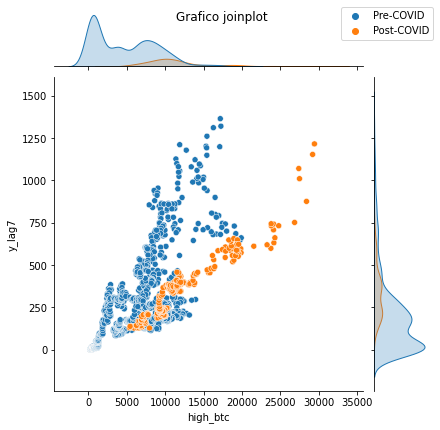

In [8]:
# Comparación precio bitcoin contra precio ethereum predicho 
# para la semana siguiente según el shock de COVID 

p = sns.jointplot(data=train, x="high_btc", y="y_lag7", hue='Shock-COVID')
p.fig.suptitle("Grafico joinplot")

#omito la legenda default
p.ax_joint.legend_._visible=False
p.fig.legend(bbox_to_anchor=(1, 1), loc=1);

In [9]:
import plotly.express as px

# grafico 3dimenseiones 
fig = px.scatter_3d(train, x='high_btc', y='y_lag1', z='Shock-COVID', size='y_lag1',
              color='y_lag1', opacity=0.8)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                  title={
        'text': "Grafico 3D de impacto COVID",
        'y':0.9,
        'x':0.05
         })
fig.show()

ModuleNotFoundError: No module named 'plotly'

**Gráficos PairPlot agrupado por Pre y Post COVID**

<Figure size 1152x720 with 0 Axes>

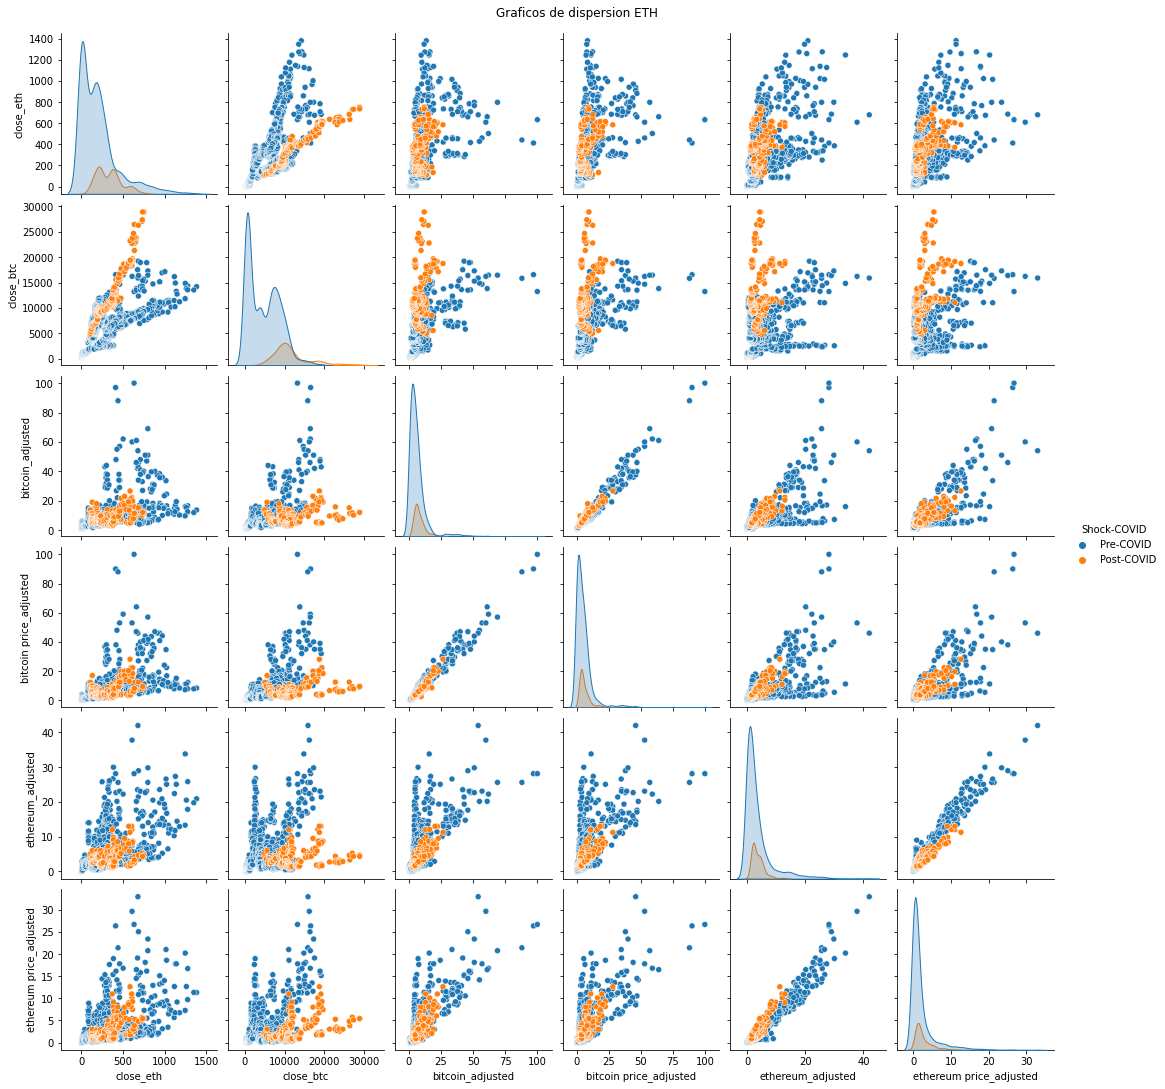

In [ ]:
df_grafico = train[['close_eth', 'close_btc', 'bitcoin_adjusted', 'bitcoin price_adjusted', 'ethereum_adjusted', 'ethereum price_adjusted', 'Shock-COVID']]

plt.figure(figsize=(16, 10))
g = sns.pairplot(df_grafico, hue='Shock-COVID')
g.fig.suptitle("Graficos de dispersion ETH", y=1.01);

### Período pre y post Binance

**Gráficos PairPlot agrupado por Pre y Post Binance**

<Figure size 1152x720 with 0 Axes>

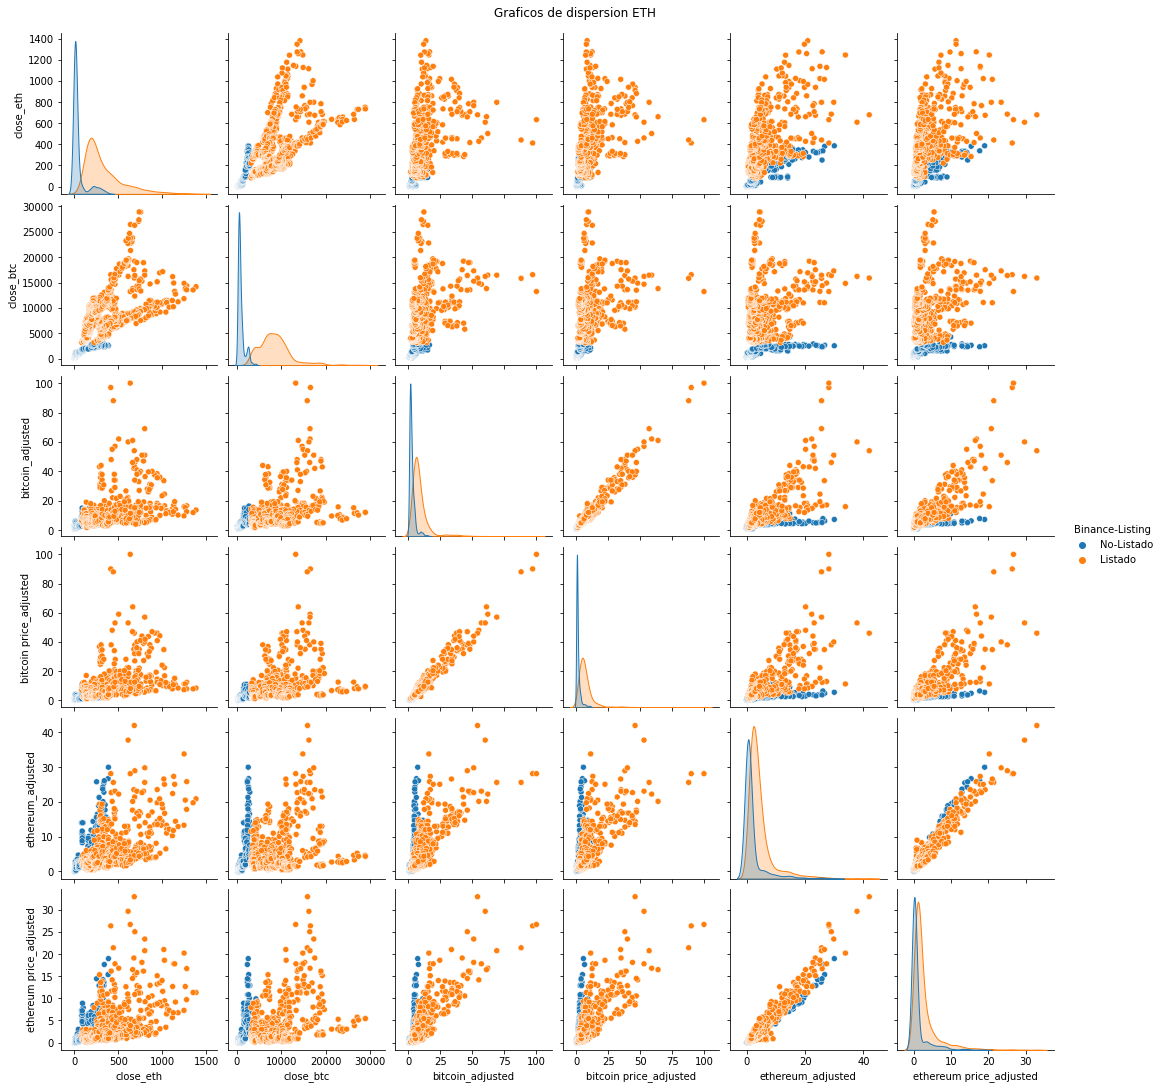

In [ ]:
df_grafico = train[['close_eth', 'close_btc', 'bitcoin_adjusted', 'bitcoin price_adjusted', 'ethereum_adjusted', 'ethereum price_adjusted', 'Binance-Listing']]

plt.figure(figsize=(16, 10))
g = sns.pairplot(df_grafico, hue='Binance-Listing')
g.fig.suptitle("Graficos de dispersion ETH", y=1.01);